# Precipitation measurements

Example of homemade rain gauge precipitation measurements with the help of kids toy-buckets and some bayesian mathematics.

See https://en.wikipedia.org/wiki/Rain_gauge

Measurements were done overnight between 24.-25.7.2020.

## Weather station measurements
Espoo, Nuuksio, <15 km from the measurement location  
Espoo, Tapiola, <15 km from the measurement location  
https://www.ilmatieteenlaitos.fi/havaintojen-lataus

## Problem definition

The aim is to estimate precipitation based on simple measurement setup.
Two buckets (blue and yellow) were left outside overnight to gather rain precipitation.
The diameter of the bucket was measured a few times with a tape measure.
At the morning next day, the buckets were weighted with and without the precipitated water.
Scale was tared between the measurements and the buckets were placed approximately center.

Scale used for the weighting has approximately absolute accuracy of +/- 2 grams and the result is rounded to the closest 1 gram.
Tape measure results were inferred from the photograph and are given +/- 2 centimeter accuracy.

In [1]:
import os
import pystan
import numpy as np
import pandas as pd
import arviz as az

## FMI Measurement data

In [2]:
fmi_data = pd.read_csv("./FMI_DATA/precipitation.csv", index_col=0)
fmi_data

,Precipitation overnight (mm)
Nuuksio,1.350000
Tapiola,4.066667


# Data

In [3]:
import pickle

In [4]:
with open("DATA/measurement_data.pickle", "rb") as f:
    data = pickle.load(f)

In [5]:
data.keys()

dict_keys(['weight_bucket', 'weight_bucket_water', 'diameter', 'radius', 'wedge_outer', 'wedge_inner', 'wedge_length', 'density_water'])

# Let's solve this with Stan and at some uncertainty

This kind of data use ragged structure, even when this example has same number of measurements for different groups (buckets).

For ragged structure see https://mc-stan.org/docs/2_23/stan-users-guide/ragged-data-structs-section.html

In [6]:
from pathlib import Path

In [7]:
stan_file = Path("./Stan_models/continuous_error_model.stan")

In [8]:
model_code = """
functions {
    real bucket_area(real r, real d_i, real d_o, real d_l) {
        real circle_area = pi() * square(r);
        
        real p = (r * 2 + d_i) / 2;
        real segment_angle = 2 * pi() * d_i / (2 * pi() * r);
        real segment_area = 0.5 * square(r) * (segment_angle - sin(segment_angle));
        
        real wedge_area = d_i * d_l + fabs(d_i - d_o) * d_l;
        real area = circle_area - segment_area + wedge_area;
        return area;
    }
}
data {
    int<lower=0> K;             // # of buckets
    
    // Weigths
    
    int<lower=0> N_b;           // # of observations for weight (bucket)
    vector[N_b] w_b;            // bucket weight observations (bucket) [g]
    int s_b[K];                 // bucket weight group sizes (bucket)

    int<lower=0> N_bw;          // # of observations for weight (bucket + water)
    vector[N_bw] w_bw;          // bucket weight observations (bucket + water) [g]
    int s_bw[K];                // bucket weight group sizes (bucket + water)
    
    // Lenghts
    
    int<lower=0> N_d;           // # of observations for diameter
    vector[N_d] d;              // bucket diameter observations [cm]
    int s_d[K];                 // bucket diameter group sizes
    
    int<lower=0> N_di;          // # of observations for inner length
    vector[N_di] d_i;           // bucket inner length observations [cm]
    int s_di[K];                // bucket inner length group sizes
    
    int<lower=0> N_do;          // # of observations for outer length
    vector[N_do] d_o;           // bucket outer length observations [cm]
    int s_do[K];                // bucket inner length group sizes
    
    int<lower=0> N_dl;          // # of observations for length
    vector[N_dl] d_l;           // bucket length observations [cm]
    int s_dl[K];                // bucket length group sizes
    
}
transformed data {
    real scale_sd = sqrt(2);            // estimated absolute error
    real tape_measure_sd = sqrt(2);     // estimated absolute error
    real density_water = 999;           // kg/m^3 for water at 15 degC 
                                        // real temperature between 
                                        // 15 degC (999 kg/m^3) and 25 degC (997 kg/m^3))
}
parameters {
    // estimated true values
    vector<lower=0>[K] weight_bucket;
    vector<lower=0>[K] weight_bucket_water;
    vector<lower=0>[K] diameter;
    vector<lower=0>[K] d_inner;
    vector<lower=0>[K] d_outer;
    vector<lower=0>[K] d_length;
}
transformed parameters {
    vector<lower=0>[K] radius = diameter ./ 2;
    vector<lower=0>[K] weight_water = weight_bucket_water - weight_bucket;
    vector<lower=0>[K] area;
    for (k in 1:K) {
        area[k] = bucket_area(radius[k], d_inner[k], d_outer[k], d_length[k]);
    }
}
model {
    int pos_b = 1;
    int pos_bw = 1;
    int pos_d = 1;
    int pos_di = 1;
    int pos_do = 1;
    int pos_dl = 1;
    
    for (k in 1:K) {
        segment(w_b, pos_b, s_b[k]) ~ normal(weight_bucket[k], scale_sd);
        pos_b = pos_b + s_b[k];
        
        segment(w_bw, pos_bw, s_bw[k]) ~ normal(weight_bucket_water[k], scale_sd);
        pos_bw = pos_bw + s_bw[k];
        
        segment(d, pos_d, s_d[k]) ~ normal(diameter[k], tape_measure_sd);
        pos_d = pos_d + s_d[k];
        
        segment(d_i, pos_di, s_di[k]) ~ normal(d_inner[k], tape_measure_sd);
        pos_di = pos_di + s_di[k];
        
        segment(d_o, pos_do, s_do[k]) ~ normal(d_outer[k], tape_measure_sd);
        pos_do = pos_do + s_do[k];
        
        segment(d_l, pos_dl, s_dl[k]) ~ normal(d_length[k], tape_measure_sd);
        pos_dl = pos_dl + s_dl[k];
    }
}
generated quantities {
    // posterior predictive for weights
    vector[N_b] pred_w_b;            // bucket weight observations (bucket) [g]
    vector[N_bw] pred_w_bw;          // bucket weight observations (bucket + water) [g]
    // posterior predictive for lengths
    vector[N_d] pred_d;              // bucket diameter observations [cm]
    vector[N_di] pred_d_i;           // bucket inner length observations [cm]
    vector[N_do] pred_d_o;           // bucket outer length observations [cm]
    vector[N_dl] pred_d_l;           // bucket length observations [cm]
    
    // log-likelihood for weights
    vector[N_b] loglik_w_b;            // bucket weight observations (bucket)
    vector[N_bw] loglik_w_bw;          // bucket weight observations (bucket + water)
    // log-likelihood for lengths
    vector[N_d] loglik_d;              // bucket diameter observations
    vector[N_di] loglik_d_i;           // bucket inner length observations
    vector[N_do] loglik_d_o;           // bucket outer length observations
    vector[N_dl] loglik_d_l;           // bucket length observations
    
    // estimate precipitation [mm]
    vector[K] precipitation;
    
    {
    int pos_b = 1;
    int pos_bw = 1;
    int pos_d = 1;
    int pos_di = 1;
    int pos_do = 1;
    int pos_dl = 1;
    
    for (k in 1:K) {
        // results in mm of precipitation
        // see https://en.wikipedia.org/wiki/Precipitation#Measurement
        precipitation[k] = (weight_water[k] / density_water) / area[k] * 10000;
        
        
        ///////////////////////
        // posterior predictive
        // log-likelihood
        ///////////////////////
        for (n in pos_b:pos_b+s_b[k]-1){
            pred_w_b[n] = normal_rng(weight_bucket[k], scale_sd);
            loglik_w_b[n] = normal_lpdf(w_b[n] | weight_bucket[k], scale_sd);}
        pos_b = pos_b + s_b[k];
        
        for (n in pos_bw:pos_bw+s_bw[k]-1){
            pred_w_bw[n] = normal_rng(weight_bucket_water[k], scale_sd);
            loglik_w_bw[n] = normal_lpdf(w_bw[n] | weight_bucket_water[k], scale_sd);}
        pos_bw = pos_bw + s_bw[k];
        
        for (n in pos_d:pos_d+s_d[k]-1){
            pred_d[n] = normal_rng(diameter[k], tape_measure_sd);
            loglik_d[n] = normal_lpdf(d[n] | diameter[k], tape_measure_sd);}
        pos_d = pos_d + s_d[k];
        
        for (n in pos_di:pos_di+s_di[k]-1){
            pred_d_i[n] = normal_rng(d_inner[k], tape_measure_sd);
            loglik_d_i[n] = normal_lpdf(d_i[n] | d_inner[k], tape_measure_sd);}
        pos_di = pos_di + s_di[k];
        
        for (n in pos_do:pos_do+s_do[k]-1){
            pred_d_o[n] = normal_rng(d_outer[k], tape_measure_sd);
            loglik_d_o[n] = normal_lpdf(d_o[n] | d_outer[k], tape_measure_sd);}
        pos_do = pos_do + s_do[k];
        
        for (n in pos_dl:pos_dl+s_dl[k]-1){
            pred_d_l[n] = normal_rng(d_length[k], tape_measure_sd);
            loglik_d_l[n] = normal_lpdf(d_l[n] | d_length[k], tape_measure_sd);}
        pos_dl = pos_dl + s_dl[k];
    }
    }
}
"""

with stan_file.open("w") as f:
    print(model_code, file=f)

In [9]:
if not os.environ.get("BINDER_SERVICE_HOST"):
    # skip model building and sampling steps on Binder
    %time prec_model = pystan.StanModel(file=str(stan_file), extra_compile_args=["-flto"])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc049d1f094c5c4ed6f6f38b25b4f367 NOW.


Wall time: 1min 5s


# Create pystan data

In [10]:
from helper_functions import get_stan_data

In [11]:
prec_data = get_stan_data(**data)

In [12]:
if not os.environ.get("BINDER_SERVICE_HOST"):
    # skip model building and sampling steps on Binder
    %time prec_fit = prec_model.sampling(data=prec_data)

Wall time: 4.61 s


In [13]:
if not os.environ.get("BINDER_SERVICE_HOST"):
    # skip model building and sampling steps on Binder
    idata_prec = az.from_pystan(
        posterior=prec_fit,
        observed_data=["w_b", "w_bw", "d", "d_i", "d_o", "d_l"],
        constant_data=["s_b", "s_bw", "s_d", "s_di", "s_do", "s_dl"],
        posterior_predictive=["pred_w_b", "pred_w_bw", "pred_d", "pred_d_i", "pred_d_o", "pred_d_l"],
        coords={"bucket_list" : ["blue", "yellow"]},
        log_likelihood=["loglik_w_b", "loglik_w_bw", "loglik_d", "loglik_d_i", "loglik_d_o", "loglik_d_l"],
        dims={
            "weight_bucket" : ["bucket_list"],
            "weight_bucket_water" : ["bucket_list"],
            "weight_water" : ["bucket_list"],
            "diameter" : ["bucket_list"],
            "d_inner" : ["bucket_list"],
            "d_outer" : ["bucket_list"],
            "d_length" : ["bucket_list"],
            "radius" : ["bucket_list"],
            "area" : ["bucket_list"],
            "precipitation" : ["bucket_list"],
        }
    )
    idata_prec.to_netcdf("MCMC_DATA/continuous_model.nc")
else:
    idata_prec = az.from_netcdf("MCMC_DATA/continuous_model.nc")

In [14]:
idata_prec

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [15]:
az.summary(idata_prec)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
weight_bucket[0],127.654,0.803,126.205,129.191,0.013,0.009,3694.0,3693.0,3702.0,2882.0,1.0
weight_bucket[1],128.655,0.795,127.101,130.076,0.012,0.008,4582.0,4582.0,4595.0,2823.0,1.0
weight_bucket_water[0],169.330,0.821,167.825,170.954,0.011,0.008,5601.0,5597.0,5619.0,3085.0,1.0
weight_bucket_water[1],168.344,0.802,166.926,169.914,0.011,0.008,5058.0,5058.0,5053.0,2918.0,1.0
diameter[0],13.791,1.374,11.108,16.275,0.021,0.015,4188.0,4188.0,4196.0,2520.0,1.0
diameter[1],14.006,1.419,11.189,16.604,0.024,0.017,3471.0,3471.0,3487.0,2495.0,1.0
d_inner[0],5.986,1.461,3.108,8.520,0.029,0.020,2626.0,2626.0,2803.0,1598.0,1.0
d_inner[1],5.946,1.438,3.083,8.483,0.026,0.019,2990.0,2990.0,2956.0,1608.0,1.0
d_outer[0],3.082,1.334,0.698,5.612,0.023,0.016,3408.0,3408.0,3030.0,1466.0,1.0
d_outer[1],3.044,1.368,0.402,5.510,0.028,0.020,2392.0,2392.0,2138.0,1044.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255D1AC7B08>,
      dtype=object)

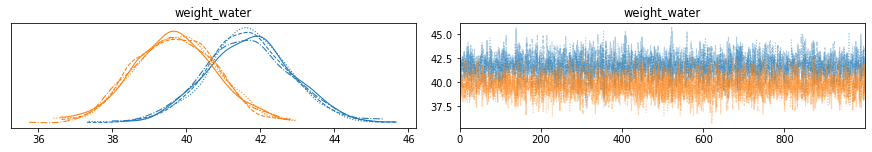

In [16]:
# blue line --> blue bucket
# orange line --> yellow bucket
az.plot_trace(idata_prec.posterior.weight_water, compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255D1E89288>,
      dtype=object)

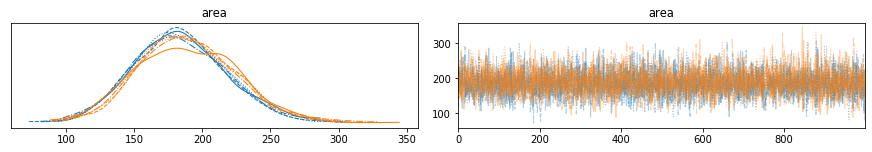

In [17]:
az.plot_trace(idata_prec.posterior.area, compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255D1F8CDC8>,
      dtype=object)

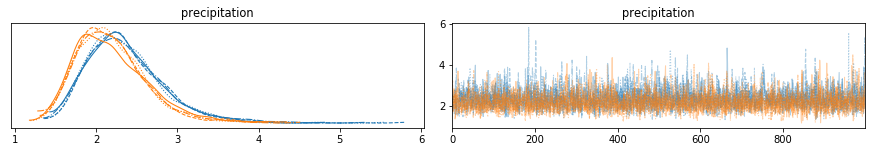

In [18]:
az.plot_trace(idata_prec.posterior.precipitation, compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255CFF9F608>,
      dtype=object)

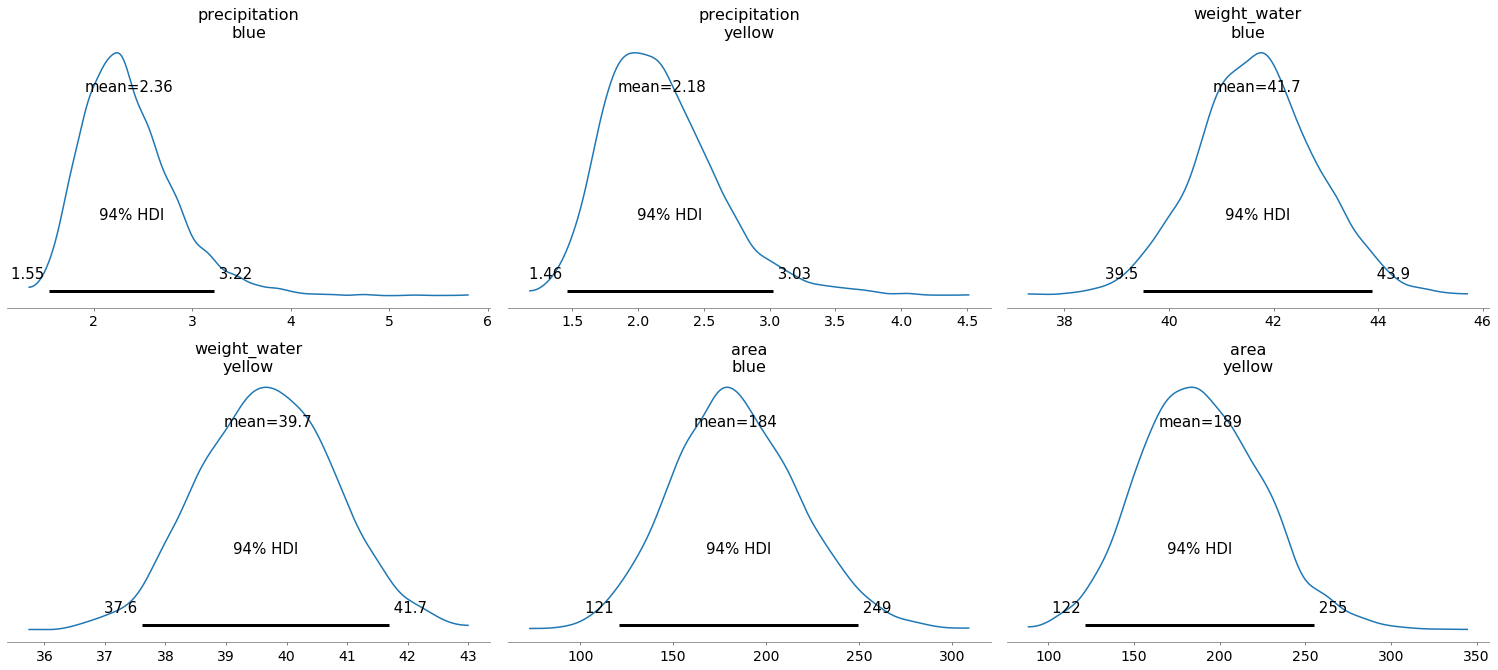

In [19]:
az.plot_posterior(idata_prec, var_names=["precipitation", "weight_water", "area"], round_to=3)

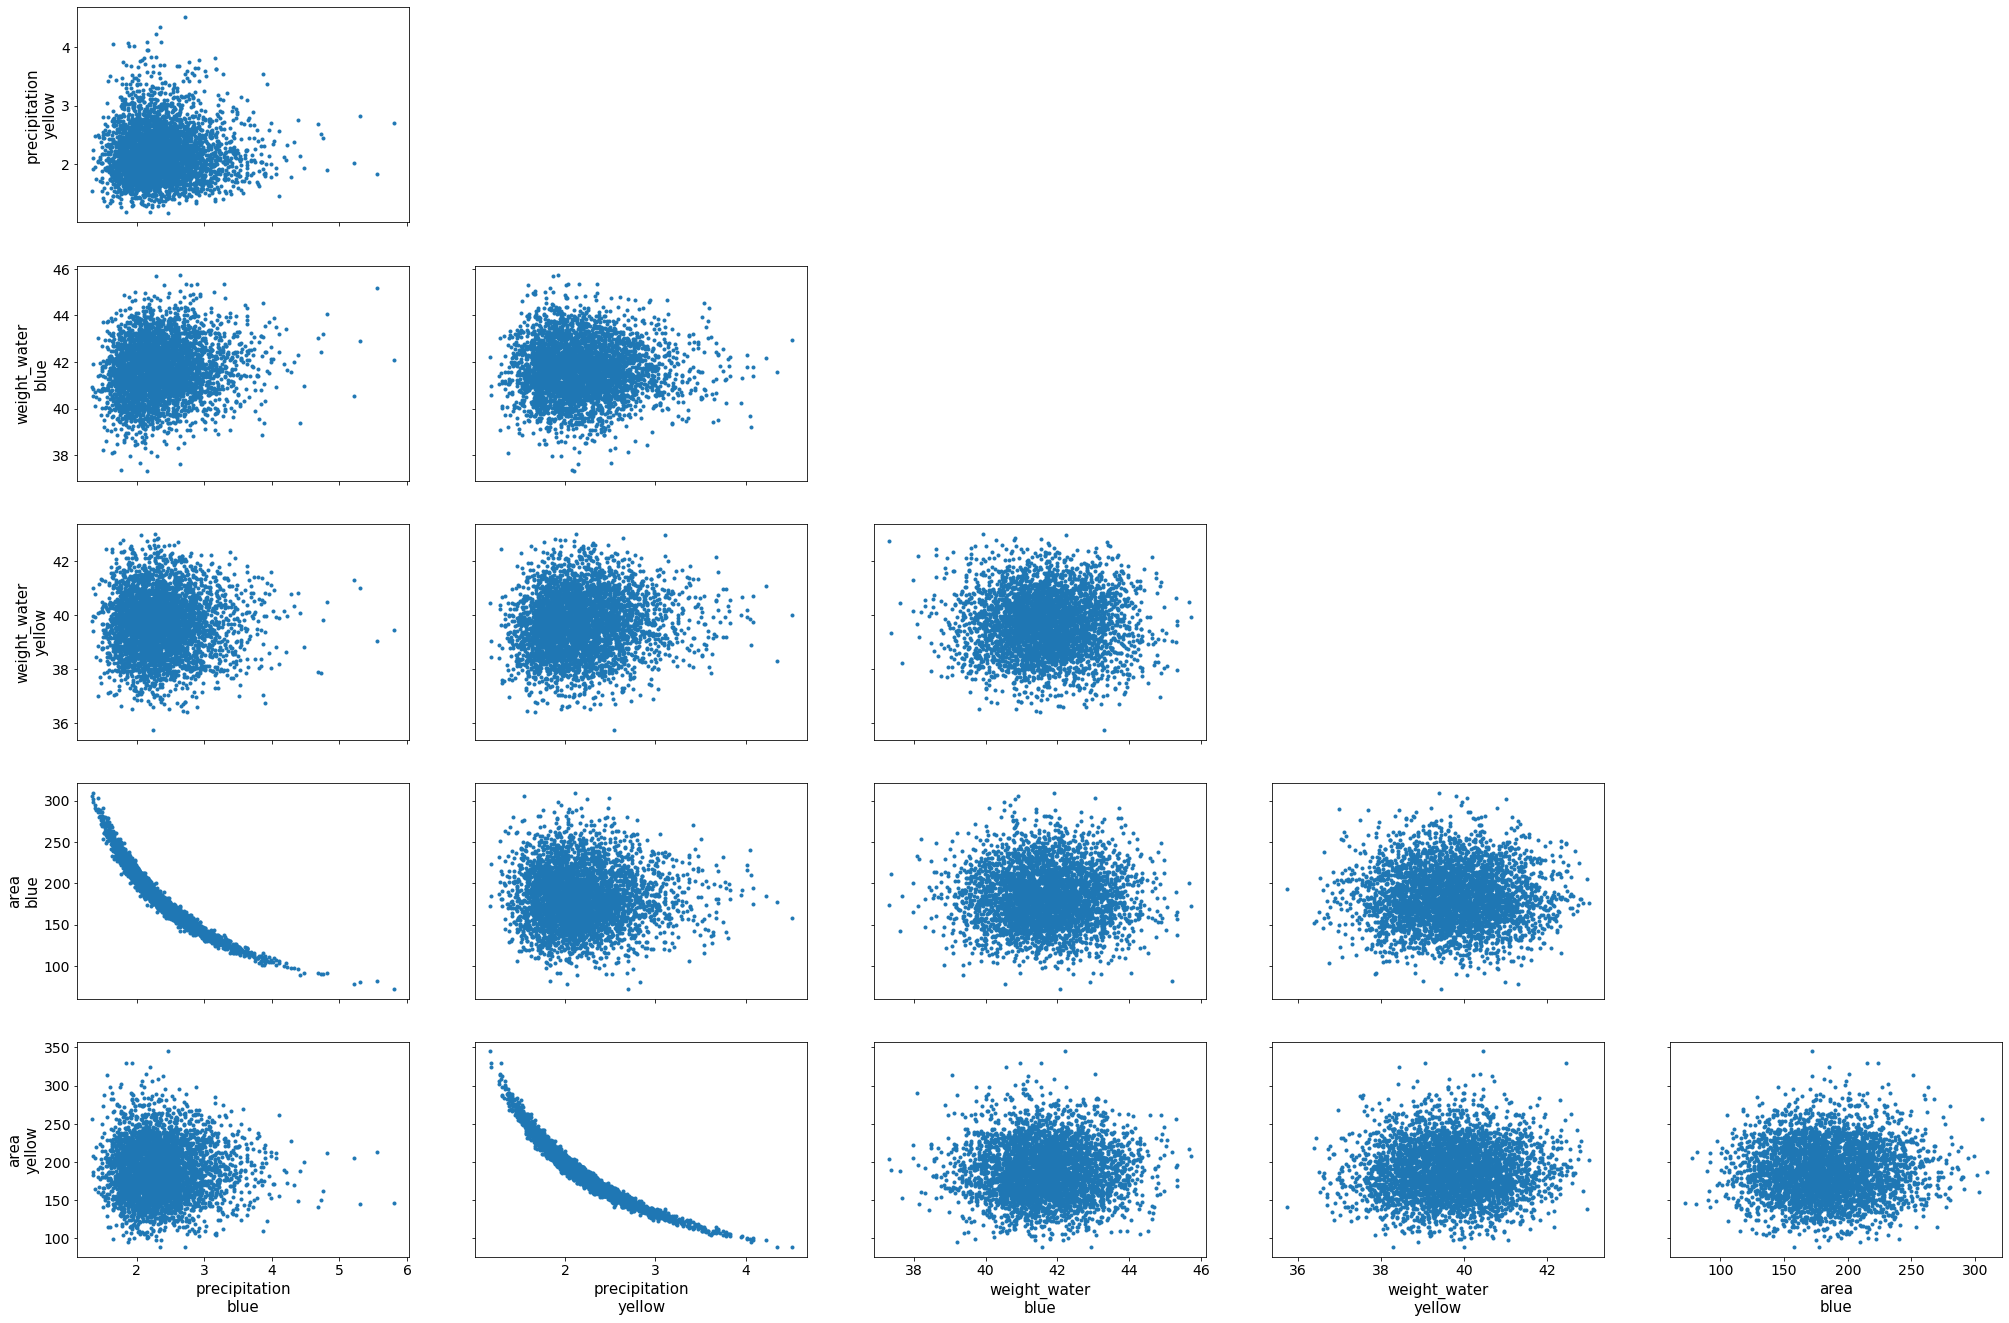

In [20]:
az.plot_pair(idata_prec, var_names=["precipitation", "weight_water", "area"], divergences=True);

## Combine precipitation measurements
This basically means that we weight each bucket equally --> 0.5, 0.5

In [21]:
precipitation_stan = idata_prec.posterior.precipitation.values.ravel()

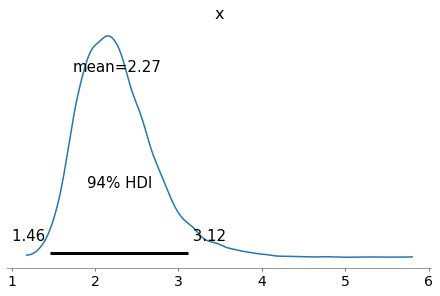

In [22]:
az.plot_posterior(precipitation_stan, round_to=3)

In [23]:
az.summary(precipitation_stan, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,2.267,0.467,1.464,3.119


# LOO

In [24]:
loo_res = []
for var in idata_prec.log_likelihood.data_vars:
    print(var)
    loo_res.append(az.loo(idata_prec, pointwise=True, var_name=var))
    print(loo_res[-1])
    print("########################################")
    print()

loglik_w_b
Computed from 4000 by 6 log-likelihood matrix

         Estimate       SE
elpd_loo    -9.25     0.13
p_loo        0.57        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        6  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

########################################

loglik_w_bw
Computed from 4000 by 6 log-likelihood matrix

         Estimate       SE
elpd_loo    -9.28     0.14
p_loo        0.58        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        6  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

########################################

loglik_d
Computed from 4000 by 2 log-likelihood matrix

         Estimate       SE
elpd_loo    -4.78     0.25
p_loo        1.58        -

There has been a warning during the calculati

c:\users\aroha\github\arviz\arviz\stats\stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
c:\users\aroha\github\arviz\arviz\stats\stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 